In [2]:
import pandas as pd
land_df = pd.read_csv('../0703/all_geo.csv')
land_df.head()

,address,lat,lng
0,新北市板橋區華東街271~300號,25.001936,121.452653
1,新北市土城區永豐路121~150號,24.984078,121.466060
2,新北市板橋區新崑路91~120號,24.999177,121.432317
3,新北市土城區延和路76巷1~30號,24.989084,121.466463
4,新北市板橋區中山路一段181~210號,25.013187,121.467601


In [17]:
import re

# 切割符號
# re.split('~', df['address'][0])

# 切割數字
address_num = re.findall('\d+', land_df['address'][0])
address_num

['271', '300']

In [18]:
import math
# 無條件進位
size = math.ceil((int(address_num[1]) - int(address_num[0]))/10)
size

3

In [26]:
address_template = ''.join(re.split('\d+', land_df['address'][0]))
address_template

'新北市板橋區華東街~號'

### 取代成特定數字

In [28]:
re.sub('\~', str(int(address_num[0])+10), address_template)

'新北市板橋區華東街281號'

In [86]:
# 產生分段的地址
address_parts = []
for i in range(0, size+1):
    # 結尾append結束數字
    if i == size:
        address_parts.append(re.sub('\~', str(address_num[1]), address_template))
    else:
        address_parts.append(re.sub('\~', str(int(address_num[0])+10*i), address_template))

address_parts

['新北市三峽區大學路1號', '新北市三峽區大學路11號', '新北市三峽區大學路21號', '新北市三峽區大學路30號']

In [37]:
# 計算不重複值(此資料已處理過)
# land_df['address'].nunique()
land_df['address'].value_counts()

新北市新莊區民安西路410巷9弄1~30號     1
新北市淡水區中正東路一段3巷14弄1~30號    1
新北市汐止區長興街二段61~90號         1
新北市汐止區福德一路151~180號        1
新北市中和區民享街89巷9弄1~30號       1
                         ..
新北市樹林區中華路379巷78弄1~30號     1
新北市林口區中正路57巷1~30號         1
新北市三重區平安街31~60號           1
新北市淡水區新春街151~180號         1
新北市新莊區中港路531巷61~90號       1
Name: address, Length: 12862, dtype: int64

In [48]:
# 找資料內不同筆但在同條路上且門牌區段不同
roads = pd.Series()
for j in range(0, land_df.shape[0]):
    roads = roads.append(pd.Series(re.split('\d+', land_df['address'][j])[0])).reset_index(drop=True)
    
roads.value_counts()

新北市中和區圓通路     85
新北市新店區安祥路     81
新北市中和區景平路     74
新北市蘆洲區長安街     74
新北市中和區連城路     69
              ..
新北市三重區光復路      1
新北市新店區直潭三街     1
新北市萬里區漁澳路      1
新北市五股區成州五路     1
新北市泰山區公園路      1
Length: 1860, dtype: int64

### 參數設定

In [11]:
from PIL import Image
import urllib.request
from urllib.parse import quote
import string
import io
from IPython.display import display
import configparser

config = configparser.ConfigParser()
config.read('Config.ini')
key1 = config.get('Keys', 'key1')
key2 = config.get('Keys', 'key2')

### 透過street view api抓圖
> https://developers.google.com/maps/documentation/streetview/intro?hl=zh_TW

### 經緯度抓

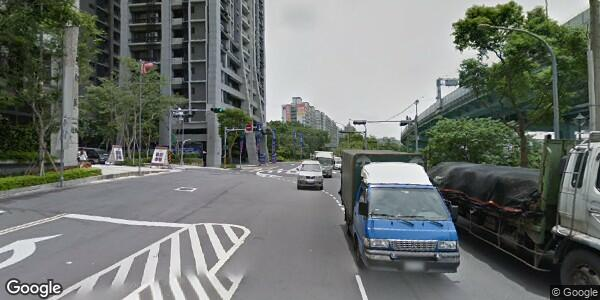

None


In [7]:
street_api = 'https://maps.googleapis.com/maps/api/streetview?location='+ str(land_df['lat'][0]) +'%2C'+ str(land_df['lng'][0]) +'&key='+ key2 +'&size=600x300'

with urllib.request.urlopen(street_api) as url:
    f = io.BytesIO(url.read())
    print(display(Image.open(f)))

### 根據地址抓

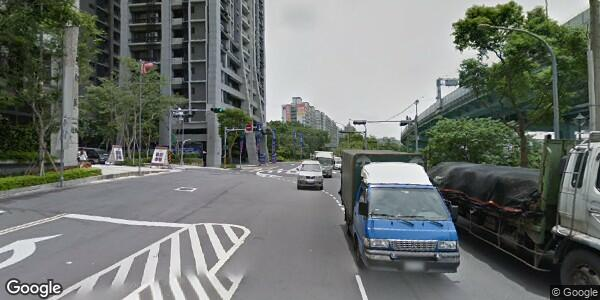

None


In [12]:
street_api_address = 'https://maps.googleapis.com/maps/api/streetview?location='+ land_df['address'][0] +'&key='+ key2 +'&size=600x300'

# 網址內有中文時要先從'ascii'轉成utf-8
street_api_address = quote(street_api_address, safe=string.printable)

with urllib.request.urlopen(street_api_address) as url:
    f = io.BytesIO(url.read())
    print(display(Image.open(f)))

### 用request比較簡潔

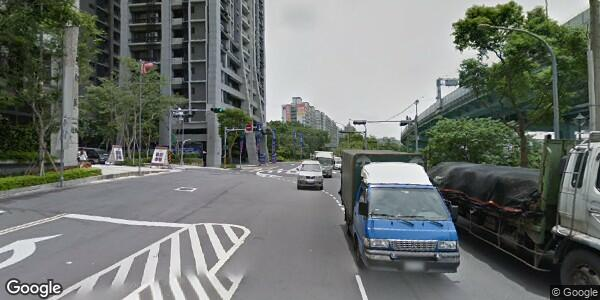

In [15]:
import requests

r = requests.get(street_api_address)
Image.open(io.BytesIO(r.content))

### 抓取同個路段的多張圖片

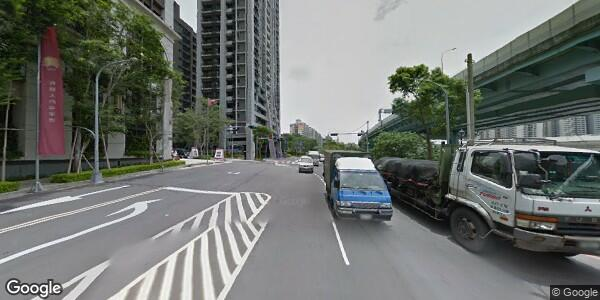

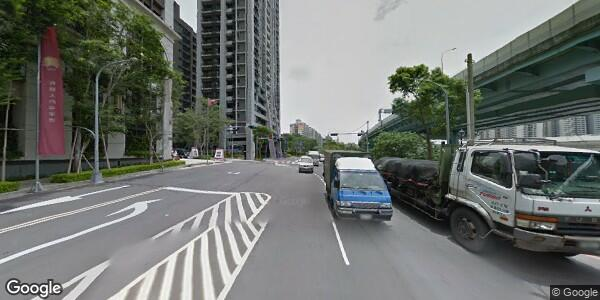

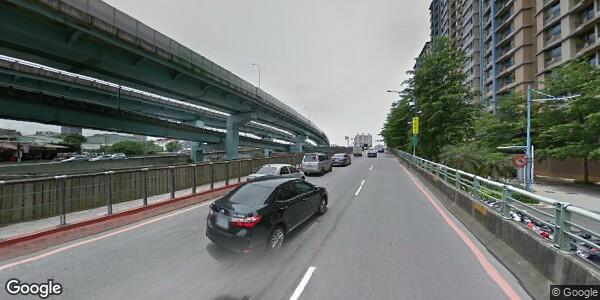

In [41]:
for j in range(0, len(address_parts)):
    part_address = 'https://maps.googleapis.com/maps/api/streetview?location='+ address_parts[j] +'&key='+ key2 +'&size=600x300&fov=120'
    r = requests.get(part_address)
    display(Image.open(io.BytesIO(r.content)))

### 存圖

In [85]:
import os

for m in range(0, 100):
    try:
        address_num = re.findall('\d+', land_df['address'][m])
        if(len(re.findall('\d+', land_df['address'][3])) > 2):
            # 存大於2個的數值(有巷/弄)
            backup_num = address_num
            # 取倒數兩個
            address_num = address_num[-2:]
        
        size = math.ceil((int(address_num[1]) - int(address_num[0]))/10)
        address_split = re.split('\d+', land_df['address'][m])
        address_template = ''.join(address_split)
        if(len(backup_num) == 3):
            #有巷
            address_split[0] = address_split[0] + backup_num[0]
            address_template = ''.join(address_split)
        if(len(backup_num) == 4):
            # 有巷也有弄
            address_split[0] = address_split[0] + backup_num[0]
            address_split[1] = address_split[1] + backup_num[1]
            address_template = ''.join(address_split)
            
        address_parts = []
        for i in range(0, size+1):
            # 結尾append結束數字
            if i == size:
                address_parts.append(re.sub('\~', str(address_num[1]), address_template))
            else:
                address_parts.append(re.sub('\~', str(int(address_num[0])+10*i), address_template))
                
        for j in range(0, len(address_parts)):
            # 如果照片不存在, 才fetch
            if(not os.path.isfile('./land_streetView/' + address_parts[j] +'.jpg')):
                part_address = 'https://maps.googleapis.com/maps/api/streetview?location='+ address_parts[j] +'&key='+ key2 +'&size=600x300&fov=120'
                r = requests.get(part_address)
                img = Image.open(io.BytesIO(r.content))
                img.save('./land_streetView/' + address_parts[j] +'.jpg', 'JPEG')
        
    except:
        continue

### 整合

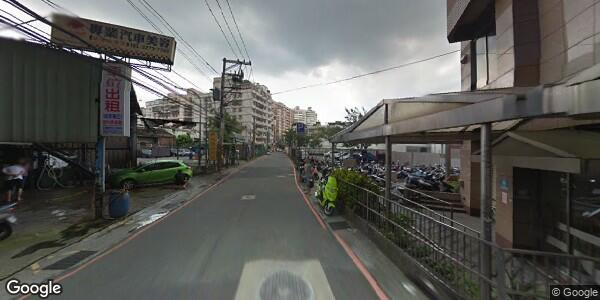

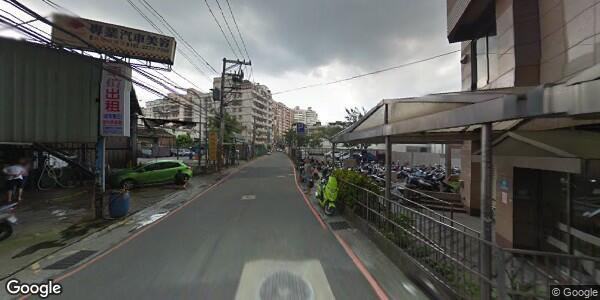

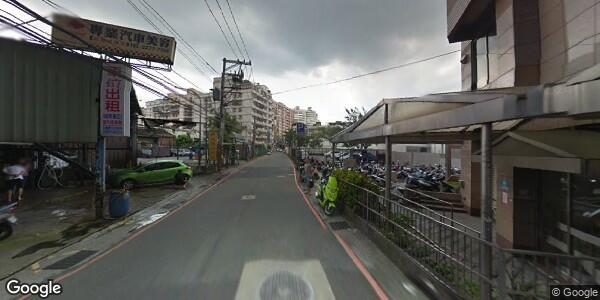

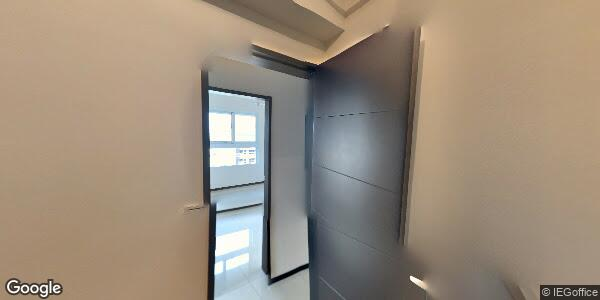

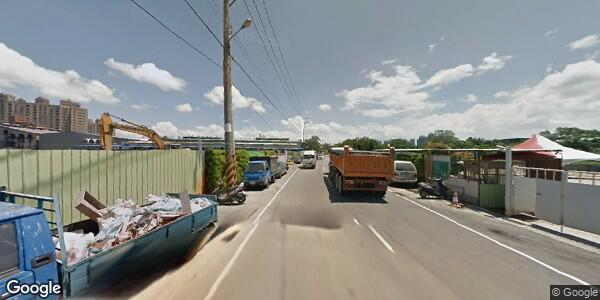

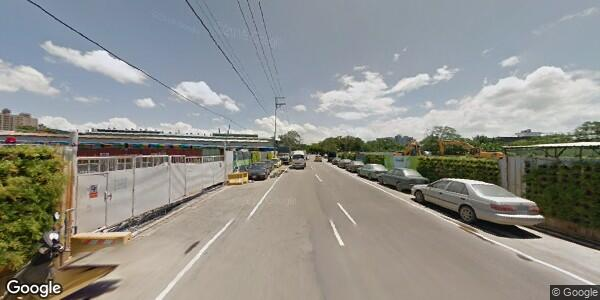

In [49]:
# for m in range(0, land_df.shape[0]):
for m in range(1, 3):
    try:
        address_num = re.findall('\d+', land_df['address'][m])
        size = math.ceil((int(address_num[1]) - int(address_num[0]))/10)
        address_template = ''.join(re.split('\d+', land_df['address'][m]))
        address_parts = []
        for i in range(0, size):
            # 結尾append結束數字
            if i == size-1:
                address_parts.append(re.sub('\~', str(address_num[1]), address_template))
            else:
                address_parts.append(re.sub('\~', str(int(address_num[0])+10*i), address_template))
                
        for j in range(0, len(address_parts)):
            part_address = 'https://maps.googleapis.com/maps/api/streetview?location='+ address_parts[j] +'&key='+ key2 +'&size=600x300&fov=120'
            r = requests.get(part_address)
            display(Image.open(io.BytesIO(r.content)))
        
    except:
        continue